In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import sys
sys.path.append("..")

P_0 = 0.6
P_1 = 1-P_0

P_00 = 0.7
P_10 = 1-P_00

P_01 = 0.5
P_11 = 1-P_01

p_z = {}
p_z[0] = P_0
p_z[1] = P_1
p_yz = {}
p_yz[0,0] = P_00
p_yz[0,1] = P_01
p_yz[1,0] = P_10
p_yz[1,1] = P_11

mu_yz = {}
mu_yz[0,0] = np.array([-0.1,-0.2])
mu_yz[0,1] = np.array([-0.2,-0.3])
mu_yz[1,0] = np.array([0.1,0.4])
mu_yz[1,1] = np.array([0.4,0.3])

sigma_yz = {}
sigma_yz[0,0] = 0.4*np.diag([1,1])
sigma_yz[0,1] = 0.2*np.diag([1,1])
sigma_yz[1,0] = 0.2*np.diag([1,1])
sigma_yz[1,1] = 0.1*np.diag([1,1])
delta = 0.5

def error_rate(theta_0, theta_1, b_0, b_1, P_z, P_yz, mu_yz, sigma_yz):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    v_1 = np.array([np.sin(theta_1),np.cos(theta_1)])
    err_0 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    err_0 += P_yz[0,0]*norm.sf((b_0-v_0.T@mu_yz[0,0])/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    err_1 = P_yz[1,1]*norm.sf((v_1.T@mu_yz[1,1]-b_1)/np.sqrt(v_1.T@sigma_yz[1,1]@v_1.T))
    err_1 += P_yz[0,1]*norm.sf((b_1-v_1.T@mu_yz[0,1])/np.sqrt(v_1.T@sigma_yz[0,1]@v_1.T))
    err = P_z[0]*err_0 + P_z[1]*err_1
    return err

def ei_violation(theta_0, theta_1, b_0, b_1, P_z, P_yz, mu_yz, sigma_yz, delta):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    v_1 = np.array([np.sin(theta_1),np.cos(theta_1)])
    p_00 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00 += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    b_0_s = b_0-delta*np.sum(np.abs(v_0))
    p_00_improvable = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00_improvable += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    p_00_improvable = p_00-p_00_improvable
    ei_0 = p_00_improvable/p_00
    p_01 = P_yz[1,1]*norm.sf((v_1.T@mu_yz[1,1]-b_1)/np.sqrt(v_1.T@sigma_yz[1,1]@v_1.T))
    p_01 += P_yz[0,1]*norm.sf((v_1.T@mu_yz[0,1]-b_1)/np.sqrt(v_1.T@sigma_yz[0,1]@v_1.T))
    b_1_s = b_1-delta*np.sum(np.abs(v_1))
    p_01_improvable = P_yz[1,1]*norm.sf((v_1.T@mu_yz[1,1]-b_1_s)/np.sqrt(v_1.T@sigma_yz[1,1]@v_1.T))
    p_01_improvable += P_yz[0,1]*norm.sf((v_1.T@mu_yz[0,1]-b_1_s)/np.sqrt(v_1.T@sigma_yz[0,1]@v_1.T))
    p_01_improvable = p_01-p_01_improvable
    ei_1 = p_01_improvable/p_01
    ei = P_z[0]*ei_0+P_z[1]*ei_1
    return max(abs(ei-ei_0),abs(ei-ei_1))

err_rate = lambda x: error_rate(x[0],x[1],x[2],x[3],p_z,p_yz,mu_yz,sigma_yz) 
ei_disp = lambda x: ei_violation(x[0],x[1],x[2],x[3],p_z,p_yz,mu_yz,sigma_yz,delta) 

from scipy.optimize import Bounds
bounds = Bounds([0, 0, -10, -10], [2*np.pi, 2*np.pi, 10, 10])

from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS
nonlinear_constraint = NonlinearConstraint(ei_disp, -0.0, 0.0, jac='2-point', hess=BFGS())

from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint([[1, -1, 0, 0]], [-0.0], [0.0])

x0 = np.array([0, 0, 0, 0])
res = minimize(err_rate, x0, method='trust-constr', constraints = [linear_constraint], options={'verbose': 1}, bounds=bounds)

from utils.dataloaders import *
dataset = SyntheticDataset(device='cpu')
train_nd, test_nd = dataset.get_dataset_in_ndarray()
X_train, Y_train, Z_train, XZ_train = train_nd
X_test, Y_test, Z_test, XZ_test = test_nd
Z_test = Z_test.astype('int32')

ei_range = np.linspace(0,ei_disp(res.x)*1.05,20)
acc_list = []
ei_list = []
acc_list_test = []
ei_list_test = []
for ei_r in ei_range:
    nonlinear_constraint = NonlinearConstraint(ei_disp, -ei_r, ei_r, jac='2-point', hess=BFGS())
    res_cons = minimize(err_rate, x0, method='trust-constr',constraints=[linear_constraint,nonlinear_constraint],options={'verbose': 1}, bounds=bounds)
    acc_list.append(err_rate(res_cons.x))
    ei_list.append(ei_disp(res_cons.x))
    decision_boundary = res_cons.x
    y_hat = (np.sum(X_test*np.array([np.sin(decision_boundary[Z_test]),np.cos(decision_boundary[Z_test])]).T,axis=1)>=np.array([decision_boundary[Z_test+2]]))*1
    y_hat_max = (np.sum(X_test*np.array([np.sin(decision_boundary[Z_test]),np.cos(decision_boundary[Z_test])]).T,axis=1)>=np.array([decision_boundary[Z_test+2]-delta*np.abs(np.sin(decision_boundary[Z_test]))-delta*np.abs(np.cos(decision_boundary[Z_test]))]))*1
    accuracy = np.mean(y_hat==Y_test)
    ei_0 = np.mean(y_hat_max[(y_hat==0)*(Z_test==0)])
    ei_1 = np.mean(y_hat_max[(y_hat==0)*(Z_test==1)])
    ei = p_z[0]*ei_0+p_z[1]*ei_1
    ei_d = max(abs(ei-ei_0),abs(ei-ei_1))
    acc_list_test.append(accuracy)
    ei_list_test.append(ei_d)


`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 85, CG iterations: 35, optimality: 4.06e-09, constraint violation: 0.00e+00, execution time: 0.035 s.
`xtol` termination condition is satisfied.
Number of iterations: 148, function evaluations: 1295, CG iterations: 144, optimality: 1.10e-01, constraint violation: 7.62e-10, execution time: 0.75 s.
`gtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 80, CG iterations: 32, optimality: 4.95e-09, constraint violation: 0.00e+00, execution time: 0.062 s.
`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 90, CG iterations: 39, optimality: 6.35e-09, constraint violation: 0.00e+00, execution time: 0.07 s.
`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 90, CG iterations: 38, optimality: 2.26e-09, constraint violation: 1.11e-16, execution time: 0.068 s.
`gtol` termination condition is s

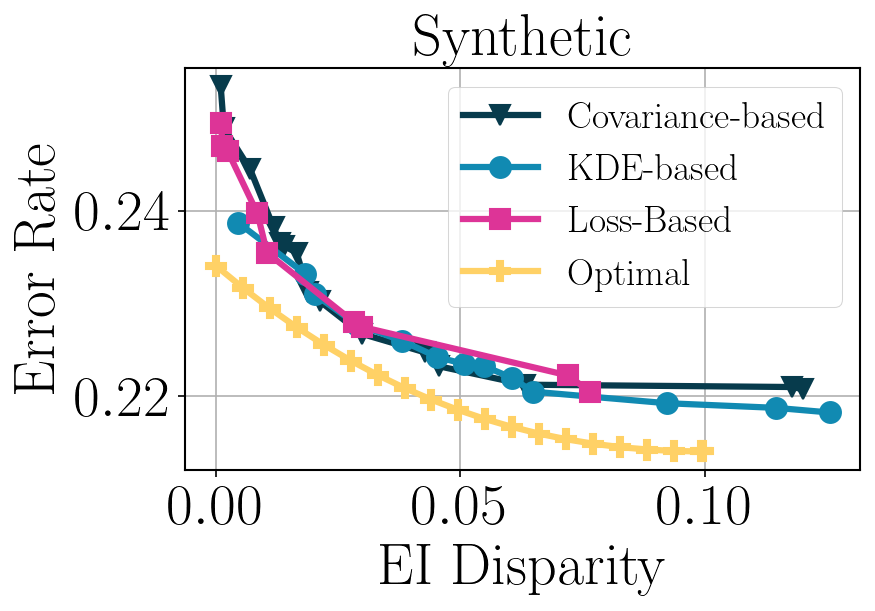

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
width = 5
height = 4

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', titlesize=28)
plt.rc('legend', fontsize=18)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots()
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(150)
colors = ['#073B4C','#118AB2','#DD3497','#FFD166']

results_fc_pareto= np.load('results/synthetic_tradeoff_fc_ei.npy')
results_kde_pareto= np.load('results/synthetic_tradeoff_kde_ei.npy')
results_fb_pareto= np.load('results/synthetic_tradeoff_fb_ei.npy')
ax.plot(results_fc_pareto[:,1],1-results_fc_pareto[:,0],label='FC',color=colors[0],marker='v',markersize=10,linewidth=3)
ax.plot(results_kde_pareto[:,1],1-results_kde_pareto[:,0],label='KDE',color=colors[1],marker='o',markersize=10,linewidth=3)
ax.plot(results_fb_pareto[:,1],1-results_fb_pareto[:,0],label='Loss App.',color=colors[2],marker='s',markersize=10,linewidth=3)
ax.plot(ei_list,acc_list,label='Optimal',color=colors[3],marker='P',markersize=10,linewidth=3)
ax.legend(('Covariance-based','KDE-based','Loss-Based','Optimal'),ncol=1)
ax.set_ylabel(r'Error Rate')
ax.set_xlabel(r'EI Disparity')
ax.set_title(r'Synthetic')
ax.grid()
plt.subplots_adjust(top=0.9,bottom=0.23,left=0.09,right=0.99)
plt.show()
# %%
